# Задание 1. A/B–тестирование
## 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

## 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

* groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

## 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

* На какие метрики Вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?

Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

## 1.4 Требования к ответу

* При выполнении тестового задания необходимо использовать язык программирования Python. 
* В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
* Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

In [185]:
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode

from tqdm.auto import tqdm

plt.style.use('ggplot')

Для начала посмотрим таблицы, которые даны:

In [186]:
public_keys = [
    'https://disk.yandex.ru/d/58Us0DWOzuWAjg',
    'https://disk.yandex.ru/d/3aARY-P9pfaksg',
    'https://disk.yandex.ru/d/prbgU-rZpiXVYg',
    'https://disk.yandex.ru/d/84hTmELphW2sqQ'
]

names = [pd.DataFrame()] * 4

In [187]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
  
for i in range(len(public_keys)):
    final_url = base_url + urlencode(dict(public_key=public_keys[i]))
    response = requests.get(final_url)
    download_url = response.json()['href']
    names[i] = pd.read_csv(download_url, sep=(',' if i == 1 else ';'))

In [188]:
groups, group_add, active_studs, checks = names[0], names[1], names[2], names[3]

In [189]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [190]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [191]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [192]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


Посмотрим, есть ли пропущенные значения

In [193]:
checks.isna().sum() 

student_id    0
rev           0
dtype: int64

In [194]:
group_add.isna().sum() 

id     0
grp    0
dtype: int64

In [195]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [196]:
active_studs.isna().sum()

student_id    0
dtype: int64

Объединим все данные в одну таблицу. active_studs содержит в себе id пользователей, которые зашли на платформу в дни проведения эксперимента, поэтому использовать будем только их. Добавим к таблице active_studs данные о группе пользователя из groups и group_add (предварительно объединив их между собой), а также даныне из checks о сумме покупки

In [197]:
groups_inf = (
    pd
    .concat([groups, group_add]) 
    .reset_index(drop=True) 
    .rename(columns={'id': 'student_id'})
)
groups_inf.head()

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [198]:
# Присоединяем информацию о группе
df = active_studs.merge(groups_inf)

In [199]:
df.groupby('grp').agg({'student_id': 'count'})

,student_id
grp,
A,1538
B,6803


In [200]:
# Смотрим, есть ли пропущенные значения
df.isna().sum() 

student_id    0
grp           0
dtype: int64

In [201]:
# Посмотрим, есть ли повторы в таблице checks (есть ли пользователи, которые делали несколько покупок)
(
    checks
    .groupby('student_id', as_index=False)
    .agg({'rev': 'count'})
    .query("rev > 1")
)

,student_id,rev


Используем left join, чтобы не потерять тех, кто заходил на сайт, но не совершил покупку (поэтому их rev = 0)

In [202]:
df = df.merge(checks, how='left').fillna(0)
df.head()

,student_id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


Посмотрим на распределения rev в группах A и B

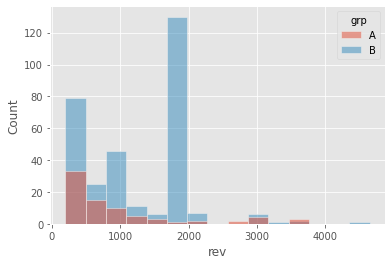

In [203]:
sns.histplot(
    data=df.query("rev > 0"),
    x='rev',
    bins=15,
    hue=df.grp
)

Посчитаем основные метрики:

In [204]:
metrics = (
    df
    .query("rev > 0")
    .groupby('grp', as_index=False)
    .agg({'student_id': 'count', 'rev': ['min', 'mean', 'median', 'max']})
    .round(2)
)

In [205]:
metrics.columns = ['grp', 'pay_users', 'min', 'mean', 'median', 'max']

In [206]:
metrics['all_users'] = [df.query("grp == 'A'").shape[0], df.query("grp == 'B'").shape[0]]
metrics['CR'] = metrics.pay_users.div(metrics.all_users).mul(100).round(2)

* pay_users - количество платящих пользователей
* min - минимальный чек
* mean - средний чек
* median - медианный чек
* max - максимальный чек
* all_users - количество пользователей, участвовавших в эксперименте и заходивших на сайт
* CR - конверсия

In [207]:
metrics

,grp,pay_users,min,mean,median,max,all_users,CR
0,A,78,199.0,933.59,585.0,3660.0,1538,5.07
1,B,314,199.0,1257.88,1140.0,4650.0,6803,4.62


Распределение не нормальное, количество пользователей в группах сильно отличается, поэтому будем использовать бутстрап по медиане

In [208]:
def get_bootstrap(data_column_1, data_column_2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, "ci": ci, "p_value": p_value}

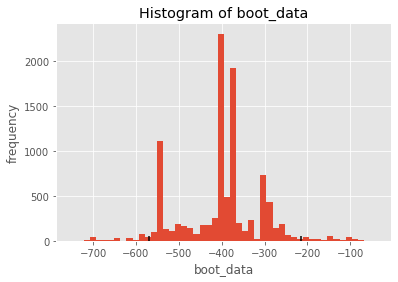

In [209]:
answ = get_bootstrap(df.query("grp == 'A' and rev > 0").rev,
                     df.query("grp == 'B' and rev > 0").rev,
                     boot_it=10000, 
                     statistic=np.median,
                     bootstrap_conf_level=0.95)

Полученное p-значение:

In [210]:
answ["p_value"]

2.645692642261017e-05

Посмотрим метрики еще раз:

In [211]:
metrics

,grp,pay_users,min,mean,median,max,all_users,CR
0,A,78,199.0,933.59,585.0,3660.0,1538,5.07
1,B,314,199.0,1257.88,1140.0,4650.0,6803,4.62


## Вывод
* p < 0.05 - получены статистически значимые различия
* Средний чек увеличился
* Конверсия уменьшилась

Исходя из того, конверсия уменьшилась, несмотря на то, что средний увеличился и различия статистички значимы, я думаю, пока что не стоит вводить изменения для всех пользователей. 

# Задание 2. SQL
## 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин за час.

### 2.1.2 Задача

Дана таблица peas:

| Название атрибута | Тип атрибута | Смысловое значение |
| ------------- |-------------| -----|
| st_id     | int |ID ученика |
| timest      | timestamp      |Время решения карточки |
| correct |	bool    |Правильно ли решена горошина? |
|subject|	text|Дисциплина, в которой находится горошина |

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

### Решение
PostreSQL

Предположим, что в таблице данные только за март

Для удобства создадим табличное выражение, которое возвращает строки, где correct = true, а время решения представлено в unix-формате

```
WITH peas_true AS (
        SELECT
            st_id,
            EXTRACT(EPOCH FROM timest) AS timest
        FROM peas
        WHERE correct = true
     )
```

При помощи оконных функций будем работать с каждым студентом отдельно (PARTITION BY st_id) и отсортируем строки по возрастанию времени (ORDER BY timest ASC) решения. Таким образом, получится, что если разность между решением 20 задачи и 1, 21 и 2 и т.д меньше 3600, то задача, решенная в 20 (21 и т.д) строке является 20 правильно решенной задачей за час (т.к в таблице мы оставили только правильно решенные задания и отсортировали их по времени

Фукнция LAG будет возвращать 0 для первых 19 строк каждого студента. Там образом timest - LAG(val, 19, 0) будет больше 3600

Описанные выше действия решает подзапрос. В основновном запросе оставляем только те строки, для которых полученная разность во времени меньше 3600. То есть те задачи, которые являлись 20 правильно решенной задачей за час. COUNT (DISTINCT st_id) посчитает количество уникальных студентов, которые есть в этой таблице

```
SELECT
    COUNT (DISTINCT st_id) AS cnt
FROM (
    SELECT
        st_id,
        timest - LAG(val, 19, 0) OVER w AS timest_diff
    FROM peas_true
    WINDOW w AS (PARTITION BY st_id ORDER BY timest ASC)
) AS a
WHERE timest_diff <= 3600
```

## 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

Дана таблицы: peas (см. выше), studs:

|Название атрибута	|Тип атрибута |	Смысловое значение|
| ------------- |:-------------:| -----:|
|st_id|	int 	|ID ученика|
|test_grp|	text |	Метка ученика в данном эксперименте|

и checks:

|Название атрибута|	Тип атрибута |	Смысловое значение|
| ------------- |:-------------:| -----:|
|st_id|	int |	ID ученика|
|sale_time	|timestamp	|Время покупки|
|money|	int|	Цена, по которой приобрели данный курс|
|subject	|text 	|Дисциплина, на которую приобрели полный доступ|

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

- ARPU (Average Revenue Per User) = (Общий доход за период) ÷ (Количество пользователей за период)
- ARPAU (Average Revenue Per Active User) = (Общий доход за период) ÷ (Количество активных пользователей за период)
- CR в покупку = (Число пользователей, купивших курс) ÷ (Общее количество пользователей) × 100
- СR активного пользователя в покупку = (Число активных пользователей, купивших курс) ÷ (Общее количество пользователей) × 100
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике = (Число пользователей, купивших курс по математике) ÷ (Общее количество пользователей, которые приступили к курсу по математике) × 100

Будем считать, что данные в таблицах предоставлены за нужный расчетный период. Активными будем считать пользователей, которые за месяц (т.к по предлположению в таблицах данные только март) решали задачи хотя бы 8 дней. 

Пользователи, участвующие в эксперименте:
```
WITH users AS (
        SELECT
            st_id
        FROM studs
        WHERE test_grp LIKE 'test'
)
```

Пользователи, приносящие доход и участвующие в эксперименте:
```
WITH check_users AS (
        SELECT
            l.st_id AS st_id,
            money,
            subject
        FROM checks AS l
        JOIN studs AS r ON l.st_id = r.st_id	
        WHERE test_grp LIKE 'test'
)
```

Активные пользователи:

```
WITH active_users AS (
        SELECT
            st_id,
            COUNT(Day)
        FROM (
            SELECT
                st_id,
                EXTRACT(DAY FROM timest) AS Day
            FROM peas
        ) AS a
        GROUP BY st_id
        HAVING COUNT(Day) >= 8
)
```

Пользоваетли, которые приступили к курсу по математике:
```
WITH math_users AS (
        SELECT
            st_id
        FROM peas AS l
        JOIN studs AS r ON l.st_id = r.st_id    
        WHERE test_grp LIKE 'test' AND subject LIKE  ’math’    
)
```

Итоговоый запрос:
```
SELECT
    (SELECT SUM(money) FROM check_users) / (SELECT COUNT(st_id) FROM users) AS ARPU,
    (SELECT SUM(money) FROM check_users) / 
    (SELECT COUNT(st_id) FROM users WHERE st_id IN (SELECT st_id FROM active_users)) AS ARPAU, 
    (SELECT COUNT(DISTINCT st_id) FROM check_users) / (SELECT COUNT(st_id) FROM users) * 100 AS CR,
    (SELECT COUNT(DISTINCT st_id) FROM check_users WHERE st_id IN (SELECT st_id FROM active_users)) 
    / (SELECT COUNT(st_id) FROM users) * 100 AS CR_active,
    (SELECT COUNT(DISTINCT st_id) FROM check_users WHERE subject LIKE  ’math’ )
    /(SELECT COUNT(DISTINCT st_id) FROM math_users) * 100 AS CR_math      
```

# Задание 3. Python
## 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Структура основноного датафрейма, полученного в 1 задании:

In [212]:
df.head()

,student_id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


Тестовый groups_add.csv:

In [213]:
df_test = pd.DataFrame()
df_test['student_id'] = list(range(df.student_id.max() + 1, df.student_id.max() + 51))
df_test['grp'] = [random.choice(['A', 'B']) for _ in range(50)]
df_test['rev'] = [random.choice([0, 0, 0, 128, 256, 512, 1024, 2048]) for _ in range(50)]
df_test.head()

,student_id,grp,rev
0,5951798,A,0
1,5951799,A,256
2,5951800,B,0
3,5951801,A,512
4,5951802,A,0


## Задание 1
Функция add_new_data будет возвращать сам датафрейм с новыми данными и датафрейм с пересчитанными метриками, выбранными в задании 1.

В задании сказано, что заголовки могут отличаться, но предположим, что их порядок известен: 1 столбец - id, 2 столбец - группа, 3 столбец - чек (если 3 столбец пропущен, то пользователь не заходил на платформу и его данные не учитываются)

In [214]:
def add_new_data(df_old, df_new):
    if len(df_new.columns) == 3:
        df_new.columns = ['student_id', 'grp', 'rev']
        df = pd.concat([df_old, df_new], ignore_index=True)
    else:
        df = df_old.copy()
        
    metrics = (
        df
        .query("rev > 0")
        .groupby('grp', as_index=False)
        .agg({'student_id': 'count', 'rev': ['min', 'mean', 'median', 'max']})
        .round(2)
    )
        
    metrics.columns = ['grp', 'pay_users', 'min', 'mean', 'median', 'max']
    metrics['all_users'] = [df.query("grp == 'A'").shape[0], df.query("grp == 'B'").shape[0]]
    metrics['CR'] = metrics.pay_users.div(metrics.all_users).mul(100).round(2)
    
    return df, metrics

In [215]:
# Старые метрики (из задания 1)
metrics

,grp,pay_users,min,mean,median,max,all_users,CR
0,A,78,199.0,933.59,585.0,3660.0,1538,5.07
1,B,314,199.0,1257.88,1140.0,4650.0,6803,4.62


In [216]:
# Добавляем данные
new_df, new_metrics = add_new_data(df, df_test)

In [217]:
# Новые метрики
new_metrics

,grp,pay_users,min,mean,median,max,all_users,CR
0,A,94,128.0,927.19,580.0,3660.0,1564,6.01
1,B,323,199.0,1250.57,1140.0,4650.0,6827,4.73


## Задание 3
Функция get_charts строит распределение и боксплот rev по полученному датафрейму, а также 

In [218]:
def get_charts(df, metrics):
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    
    sns.histplot(
        data=df.query("rev > 0"),
        x='rev',
        bins=15,
        hue=df.grp,
        ax=axes[0][0]
    )
    
    sns.boxplot(data=df.query("rev > 0"), y='rev', x='grp', ax=axes[0][1]) 
    sns.barplot(y='grp', x='mean', data=metrics, ax=axes[1][0])    
    sns.barplot(y='grp', x='CR', data=metrics, ax=axes[1][1])

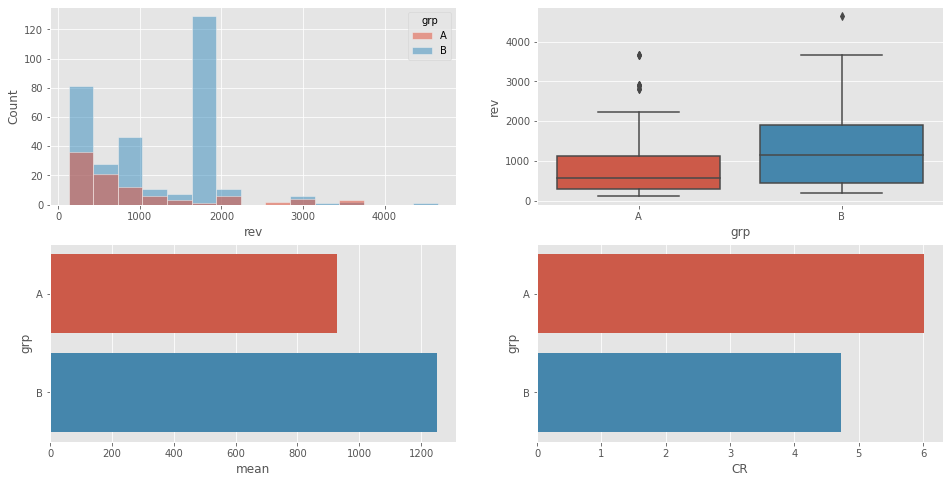

In [219]:
get_charts(new_df, new_metrics)